In [1]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.pyplot import imread

# Get directories paths

In [2]:
cur_path = os.getcwd()
work_dir = os.path.join(cur_path.rsplit('/', 1)[0], "public")
data_dir = os.path.join(work_dir, "dataset")

# Load dimensions of images for analysis

In [3]:
data = []

for filename in os.listdir(data_dir):
    name, ext = os.path.splitext(filename)
    try:
        img = imread(os.path.join(data_dir, filename))
        d1, d2, color = img.shape
        t = ""
        if "Erithacus" in filename:
            t = "Erithacus"
        elif "Periparus" in filename:
            t = "Periparus"
        elif "Pica" in filename:
            t = "Pica"
        else:
            t = "Turdus"
        data.append([d1, d2, t])      
    except:
        continue

# Plot images dimensions to see size distribution of images in dataset
### 

In [5]:
df = pd.DataFrame(data=data, columns=["d1", "d2", "color"])

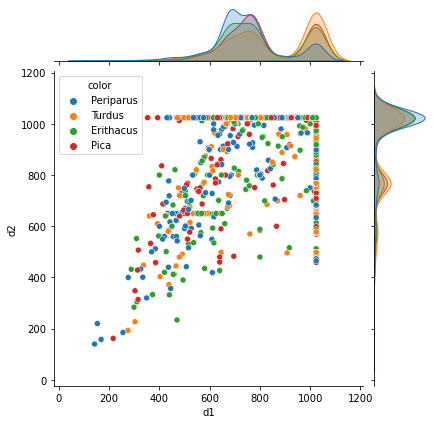

In [6]:
sns.jointplot(data=df, x="d1", y="d2", hue="color")

# More information about pictures
### We can see substantial difference between minimum and maximum resolution values. Images cannot be resized to either of those values as many pictures would become very distorted. Finding optimal values (between min and max) for image resizing will be crucial for training.

In [ ]:
df = pd.DataFrame(data={"Min": {"Height": np.min(dim2), "Width": np.min(dim1)},
                       "Max": {"Height": np.max(dim2), "Width": np.max(dim1)},
                       "Mean": {"Height": round(np.mean(dim2), 2), "Width": round(np.mean(dim1), 2)}
                       },
                 )
df